<a href="https://colab.research.google.com/github/sunny1c/Dacon/blob/master/titanic_200127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 업로드
### 변수 설명
* PassengerId : 승객 번호

- Survived : 생존여부(1: 생존, 0 : 사망)

- Pclass : 승선권 클래스(1 : 1st, 2 : 2nd ,3 : 3rd)

- Name : 승객 이름

- Sex : 승객 성별

- Age : 승객 나이 

- SibSp : 동반한 형제자매, 배우자 수

- Patch : 동반한 부모, 자식 수

- Ticket : 티켓의 고유 넘버

- Fare 티켓의 요금

- Cabin : 객실 번호

- Embarked : 승선한 항구명(C : Cherbourg, Q : Queenstown, S : Southampton)

In [0]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## 분석 커널
https://www.kaggle.com/poonaml/titanic-survival-prediction-end-to-end-ml-pipeline/data
<br><br>
### 순서
*   Introduction
1.   기초 통계량 추출
2.   결측 컬럼 찾기
*   Visualizations
1.   target 컬럼과의 상관관계분석
*   Missing values imputation
1.   학습 데이터 결측 컬럼 imputation - Embarked,Age,Cabin
2.   테스트 데이터 결측 컬럼 imputation - Age and Fare
*   Feature Engineering
1.   가족 사이즈
2.   이름 타이틀(ms. mr. dr. 등)
3. 승객이 속한 deck
4. 범주형 자료 encoding - label encoding 사용
5. scaling
* Prediction
1. 검증셋 만들기
2. 모델 생성
3. 중요 feature 분석
4. 예측
5. 앙상블 - Majority voting
<br><br>  \* Majority voting 이란?
<br>  여러모형의 결과를 다수결 투표 방식으로 합하여 분류하는 방법
<br>  - Hard voting : 단순 투표. 개별 모형의 결과 기준
<br>  - Soft voting : 가중치 투표. 개별 모형의 조건부 확률의 합 기준
<blockquote> 예) <br>로지스틱 모형 : 1일 확률 0.8, 0일 확률 0.2
<br> 나이브 베이즈 : 1일 확률 0.7, 0일 확률 0.3
<br> TREE : 1일 확률 0.4, 0일 확률 0.6
<br> Hard voting은 모형 3개중 2개가 1로 분류 햇으므로 1로 분류
<br> Soft voting은 모형 3개의 1일 확률을 가중해서 1일 확률을 다시 계산
</blockquote>


In [0]:
import pandas as pd
import numpy as np

In [0]:
titanic = pd.read_csv("train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
titanic_test = pd.read_csv("test.csv")
titanic_test.head().T

,0,1,2,3,4
PassengerId,892,893,894,895,896
Pclass,3,3,2,3,3
Name,"Kelly, Mr. James","Wilkes, Mrs. James (Ellen Needs)","Myles, Mr. Thomas Francis","Wirz, Mr. Albert","Hirvonen, Mrs. Alexander (Helga E Lindqvist)"
Sex,male,female,male,male,female
Age,34.5,47,62,27,22
SibSp,0,1,0,0,1
Parch,0,0,0,0,1
Ticket,330911,363272,240276,315154,3101298
Fare,7.8292,7,9.6875,8.6625,12.2875
Cabin,NaN,NaN,NaN,NaN,NaN


In [0]:
titanic.shape

(891, 12)

기초 통계량 추출

In [0]:
titanic.describe()
# count를 보고 missing이 있는 컬럼 유추 가능 -- Age

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [0]:
titanic.info()
# 결측 비율과 데이터 타입, 메모리 사용량 등을 알 수 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
null_columns=titanic.columns[titanic.isnull().any()]
titanic.isnull().sum()
#titanic.isnull() 은 데이터 셀 별로 결측인지 아닌지를 t/f로 ㅍ시
# 컬럼별 결측값 수를 알 수 있는 명령어

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [0]:
# 테스트 셋 결측치 확인
titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

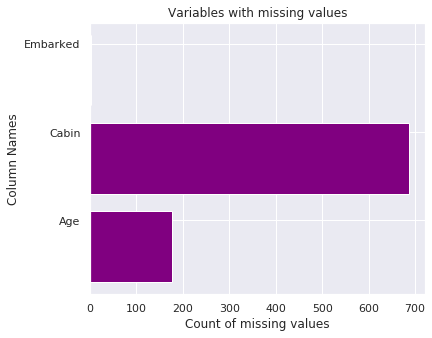

In [0]:
# 결측값 수를 그림으로 확인하자
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

# pd.options.display.mpl_style = 'default'
labels = []
values = []
for col in null_columns:
    labels.append(col)
    values.append(titanic[col].isnull().sum())
ind = np.arange(len(labels)) # barh(세로막대그래프) 의 x축에 넣기 위한 값
width=0.6
fig, ax = plt.subplots(figsize=(6,5))
rects = ax.barh(ind, np.array(values), color='purple')
ax.set_yticks(ind+((width)/2.)) # x축 레이블 위치 선정
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_ylabel("Column Names")
ax.set_title("Variables with missing values");

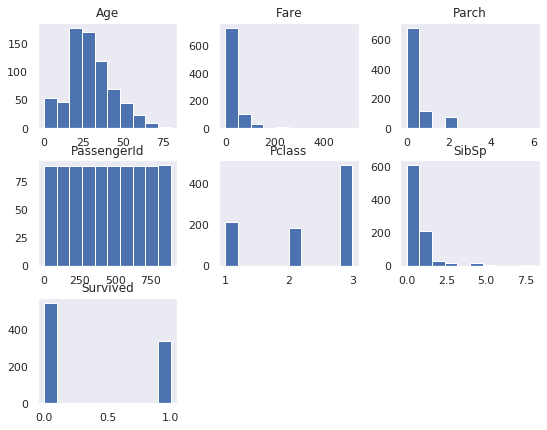

In [0]:
# 컬럼별 분포 확인
titanic.hist(bins=10,figsize=(9,7),grid=False)

연속형 변수인 age와 fare의 scale이 다르다 -> scaling 필요

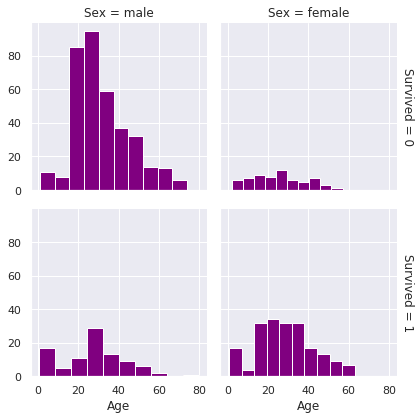

In [0]:
# 성별, 생존여부별 age의 분포
## 이건 왜 찍어보는지 이해는 안 감.. 
g = sns.FacetGrid(titanic, col="Sex", row="Survived", margin_titles=True)
g.map(plt.hist, "Age",color="purple");

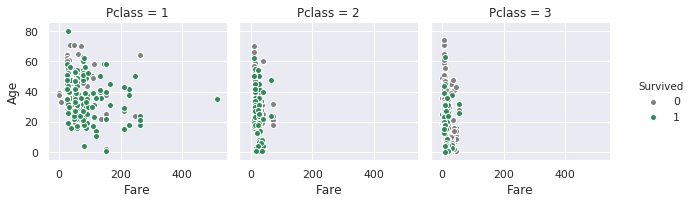

In [0]:
# Pclass별 Fare와 Age의 관계
g = sns.FacetGrid(titanic, hue="Survived", col="Pclass", margin_titles=True, palette={1:"seagreen", 0:"gray"})
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend();

Pclass 1일 때 분포가 다른 것으로 보아 세 변수가 생존여부에 교차영향을 보인다. (내 생각)

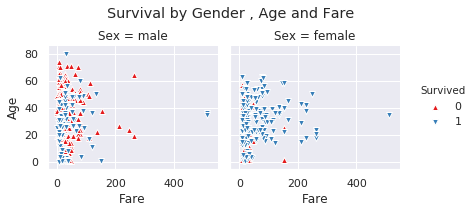

In [0]:
# 성별 age, fare, 생존 여부 분포
g = sns.FacetGrid(titanic, hue="Survived", col="Sex", margin_titles=True, palette="Set1",hue_kws=dict(marker=["^", "v"]))
# marker 조절을 v ^ 로 할 수 있음
g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Survival by Gender , Age and Fare');

여자이고 나이가 어리고 fare값이 작은 경우 생존한 경우가 많았음

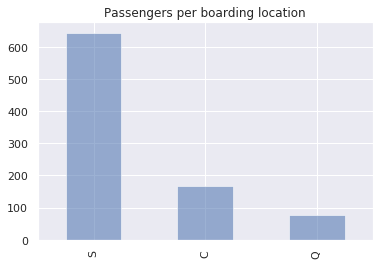

In [0]:
# 탑승 위치별 승객 수
titanic.Embarked.value_counts().plot(kind='bar', alpha=0.55)
plt.title("Passengers per boarding location");

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


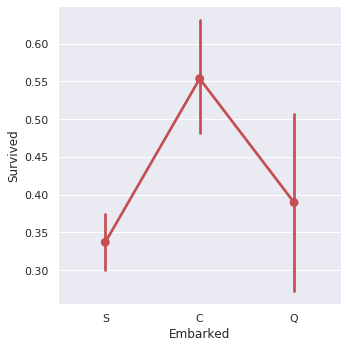

In [0]:
# 탑승 위치별 생존확률 분포(상자그림)
sns.factorplot(x = 'Embarked',y="Survived", data = titanic,color="r");

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


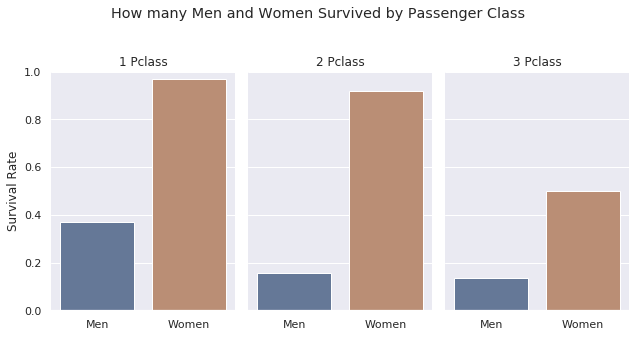

In [0]:
# 승객 클래스, 성별 생존확률
sns.set(font_scale=1)
g = sns.factorplot(x="Sex", y="Survived", col="Pclass",
                    data=titanic, saturation=.5,
                    kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Survival Rate")
    .set_xticklabels(["Men", "Women"])
    .set_titles("{col_name} {col_var}")
    .set(ylim=(0, 1))
    .despine(left=True))  
plt.subplots_adjust(top=0.8)
g.fig.suptitle('How many Men and Women Survived by Passenger Class');

여자가 생존확률이 높고 Pclass 1인 경우 생존 확률이 높음

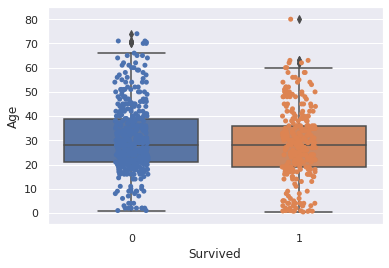

In [0]:
# 생존여부 별 나이 분포
ax = sns.boxplot(x="Survived", y="Age", data=titanic)
ax = sns.stripplot(x="Survived", y="Age", data=titanic, jitter=True, edgecolor="gray")
# sns.plt.title("Survival by Age",fontsize=12);

생존한 승객의 나이가 살짝 낮았다. 그러나 고령 승객 몇명도 있었음

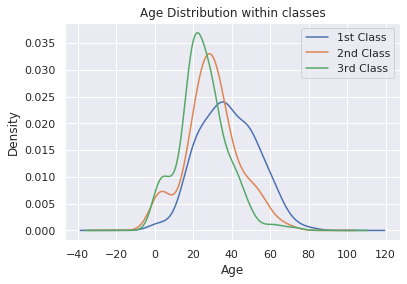

In [0]:
# 승객 클래스별 나이의 분포 
titanic.Age[titanic.Pclass == 1].plot(kind='kde')    
titanic.Age[titanic.Pclass == 2].plot(kind='kde')
titanic.Age[titanic.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') ;

클래스가 높을수록 나이가 높고, 클래스가 낮을 수록 나이가 어리다.

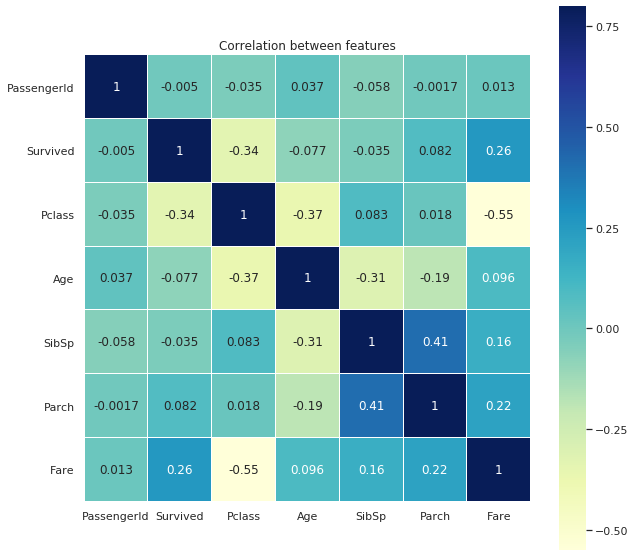

In [0]:
# 변수별 상관관계 분석
corr=titanic.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [0]:
# 생존여부와 관계가 높은 변수는?
titanic.corr()["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

클래스, 나이, 티켓요금 등이 생존 여부와 관계가 높다고 나왓으나, 이 세 변수간의 관계도 예상되기 때문에 고려할 필요가 있음
<br> Parch(동반한 부모, 자식 수)가 많을수록 생존할 확률도 높앗음

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


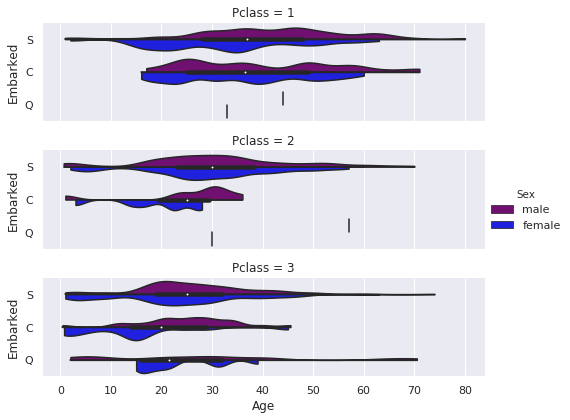

In [0]:
g = sns.factorplot(x="Age", y="Embarked",
                    hue="Sex", row="Pclass",
                    data=titanic[titanic.Embarked.notnull()],
                    orient="h", size=2, aspect=3.5, 
                   palette={'male':"purple", 'female':"blue"},
                    kind="violin", split=True, cut=0, bw=.2);

### Imputation
* svm과 같은 알고리즘은 결측치가 없는 경우만 수행 가능
* mean, median, mode로 imputation 하는 방법
* tree나 random forest 로 하는 방법

In [0]:
# 탑승 위치 컬럼 imputation
titanic[titanic['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


공통점을 찾으면, 클래스가 1등급이고, 성별이 여자, 요금이 80달러임
<br>이 중 탑승위치와 관계가 있어보이는 변수는 클래스와 요금.
<br>그래서 클래스와 요금 그래프를 그려본다

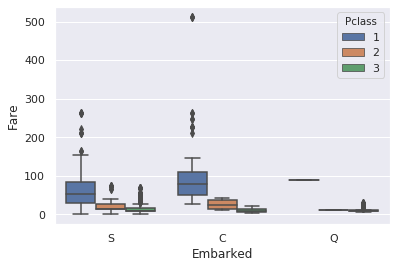

In [0]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=titanic);

1등급 클래스의 요금 중간값이 80인 경우는 embarked C 였으므로 C로 값을 채운다

In [0]:
titanic["Embarked"] = titanic["Embarked"].fillna('C')

테스트 데이터 imputation

In [0]:
titanic_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [0]:
titanic_test[titanic_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


연속형 변수이므로 3등급 클래스이고 탑승 위치가 S인 경우의 median으로 값을 imputation 한다

In [0]:
def fill_missing_fare(df):
    median_fare=df[(df['Pclass'] == 3) & (df['Embarked'] == 'S')]['Fare'].median()
#'S'
       #print(median_fare)
    df["Fare"] = df["Fare"].fillna(median_fare)
    return df

titanic_test=fill_missing_fare(titanic_test)

### Feature Engineering

In [0]:
titanic["Deck"]=titanic.Cabin.str[0]
titanic_test["Deck"]=titanic_test.Cabin.str[0]
titanic["Deck"].unique() # 0 is for null values

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


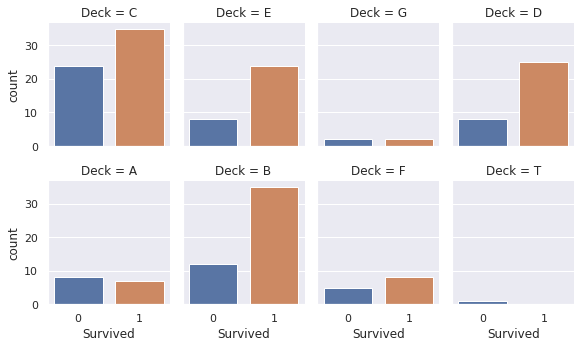

In [0]:
g = sns.factorplot("Survived", col="Deck", col_wrap=4,
                    data=titanic[titanic.Deck.notnull()],
                    kind="count", size=2.5, aspect=.8);

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


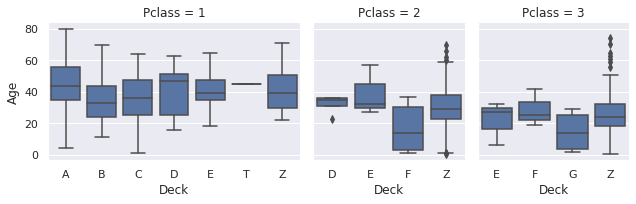

In [0]:
titanic = titanic.assign(Deck=titanic.Deck.astype(object)).sort_values("Deck")
g = sns.FacetGrid(titanic, col="Pclass", sharex=False,
                  gridspec_kws={"width_ratios": [5, 3, 3]})
g.map(sns.boxplot, "Deck", "Age");

In [0]:
titanic.Deck.fillna('Z', inplace=True)
titanic_test.Deck.fillna('Z', inplace=True)
titanic["Deck"].unique() # Z is for null values

array(['Z', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

Patch : 동반한 부모, 자식 수, SibSp : 동반한 형제자매, 배우자 수 를 합쳐서 가족의 수를 계산해보자

In [0]:
# Create a family size variable including the passenger themselves
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]+1
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]+1
print(titanic["FamilySize"].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


In [0]:
# Discretize family size
titanic.loc[titanic["FamilySize"] == 1, "FsizeD"] = 'singleton'
titanic.loc[(titanic["FamilySize"] > 1)  &  (titanic["FamilySize"] < 5) , "FsizeD"] = 'small'
titanic.loc[titanic["FamilySize"] >4, "FsizeD"] = 'large'

titanic_test.loc[titanic_test["FamilySize"] == 1, "FsizeD"] = 'singleton'
titanic_test.loc[(titanic_test["FamilySize"] >1) & (titanic_test["FamilySize"] <5) , "FsizeD"] = 'small'
titanic_test.loc[titanic_test["FamilySize"] >4, "FsizeD"] = 'large'
print(titanic["FsizeD"].unique())
print(titanic["FsizeD"].value_counts())

['small' 'singleton' 'large']
singleton    537
small        292
large         62
Name: FsizeD, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


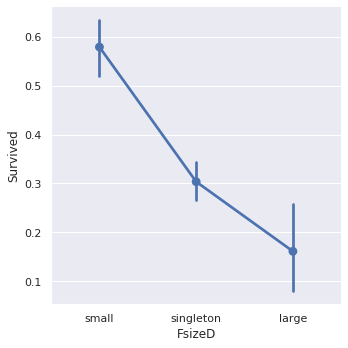

In [0]:
sns.factorplot(x="FsizeD", y="Survived", data=titanic);

이름의 길이를 분석해본다.. (이해는 안 감)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


[okay, short, good, long]
Categories (4, object): [short < okay < good < long]


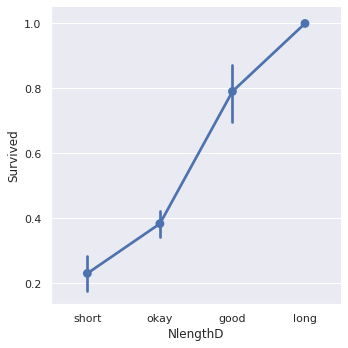

In [0]:
#Create feture for length of name 
# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))
#print(titanic["NameLength"].value_counts())

bins = [0, 20, 40, 57, 85]
group_names = ['short', 'okay', 'good', 'long']
titanic['NlengthD'] = pd.cut(titanic['NameLength'], bins, labels=group_names)
titanic_test['NlengthD'] = pd.cut(titanic_test['NameLength'], bins, labels=group_names)

sns.factorplot(x="NlengthD", y="Survived", data=titanic)
print(titanic["NlengthD"].unique())

직위를 분석해본다

In [0]:
import re

#A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

#Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))


#Add in the title column.
titanic["Title"] = titles

# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
titanic.loc[titanic["Title"] == "Mlle", "Title"] = 'Miss'
titanic.loc[titanic["Title"] == "Ms", "Title"] = 'Miss'
titanic.loc[titanic["Title"] == "Mme", "Title"] = 'Mrs'
titanic.loc[titanic["Title"] == "Dona", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Lady", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Countess", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Capt", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Col", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Don", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Major", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Rev", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Sir", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Jonkheer", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Dr", "Title"] = 'Rare Title'

#titanic.loc[titanic["Title"].isin(['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
#                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']), "Title"] = 'Rare Title'

#titanic[titanic['Title'].isin(['Dona', 'Lady', 'Countess'])]
#titanic.query("Title in ('Dona', 'Lady', 'Countess')")

titanic["Title"].value_counts()


titles = titanic_test["Name"].apply(get_title)
print(pd.value_counts(titles))

#Add in the title column.
titanic_test["Title"] = titles

# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
titanic_test.loc[titanic_test["Title"] == "Mlle", "Title"] = 'Miss'
titanic_test.loc[titanic_test["Title"] == "Ms", "Title"] = 'Miss'
titanic_test.loc[titanic_test["Title"] == "Mme", "Title"] = 'Mrs'
titanic_test.loc[titanic_test["Title"] == "Dona", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Lady", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Countess", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Capt", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Col", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Don", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Major", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Rev", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Sir", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Jonkheer", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Dr", "Title"] = 'Rare Title'

titanic_test["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Don           1
Lady          1
Ms            1
Countess      1
Mme           1
Sir           1
Jonkheer      1
Capt          1
Name: Name, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Ms          1
Dona        1
Name: Name, dtype: int64


Mr            240
Miss           79
Mrs            72
Master         21
Rare Title      6
Name: Title, dtype: int64

티켓번호를 분석해본다. 빨리 티켓팅한 사람이 생존이 높을수도..?

In [0]:
titanic["Ticket"].tail()

344    229236
346     31418
347    386525
312    250651
890    370376
Name: Ticket, dtype: object

In [0]:
titanic["TicketNumber"] = titanic["Ticket"].str.extract('(\d{2,})', expand=True) # 티켓번호에서 숫자만 추출한다.
titanic["TicketNumber"] = titanic["TicketNumber"].apply(pd.to_numeric)


titanic_test["TicketNumber"] = titanic_test["Ticket"].str.extract('(\d{2,})', expand=True)
titanic_test["TicketNumber"] = titanic_test["TicketNumber"].apply(pd.to_numeric)

In [0]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
445,446,1,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S,A,3,small,25,okay,Master,33638.0
209,210,1,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0000,A31,C,A,1,singleton,16,short,Mr,112277.0
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,A,1,singleton,25,okay,Mr,17754.0
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,A,2,small,44,good,Rare Title,17485.0
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0000,A36,S,A,1,singleton,22,okay,Mr,112050.0


In [0]:
titanic[titanic["TicketNumber"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5,E77,S,E,1,singleton,17,short,Mrs,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,19,short,Mr,NaN
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.5,NaN,S,Z,1,singleton,24,okay,Mr,NaN
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,19,short,Mr,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,31,okay,Mr,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,28,okay,Mr,NaN


In [0]:
# 별 아이디어가 없으면 median 으로 imputation 한다 
titanic.TicketNumber.fillna(titanic["TicketNumber"].median(), inplace=True)
titanic_test.TicketNumber.fillna(titanic_test["TicketNumber"].median(), inplace=True)

### 범주형 데이터 encoding

In [0]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

labelEnc=LabelEncoder()

cat_vars=['Embarked','Sex',"Title","FsizeD","NlengthD",'Deck']
for col in cat_vars:
    titanic[col]=labelEnc.fit_transform(titanic[col])
    titanic_test[col]=labelEnc.fit_transform(titanic_test[col])

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
445,446,1,1,"Dodge, Master. Washington",1,4.0,0,2,33638,81.8583,A34,2,0,3,2,25,2,0,33638.0
209,210,1,1,"Blank, Mr. Henry",1,40.0,0,0,112277,31.0000,A31,0,0,1,1,16,3,2,112277.0
96,97,0,1,"Goldschmidt, Mr. George B",1,71.0,0,0,PC 17754,34.6542,A5,0,0,1,1,25,2,2,17754.0
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",1,49.0,1,0,PC 17485,56.9292,A20,0,0,2,2,44,0,4,17485.0
806,807,0,1,"Andrews, Mr. Thomas Jr",1,39.0,0,0,112050,0.0000,A36,2,0,1,1,22,2,2,112050.0


### 모델링을 활용한 imputation

AttributeError: ignored

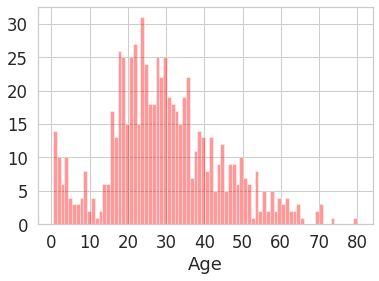

In [0]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(titanic["Age"].dropna(),
                 bins=80,
                 kde=False,
                 color="red")
    sns.plt.title("Age Distribution")
    plt.ylabel("Count");

In [0]:
from sklearn.ensemble import RandomForestRegressor
#predicting missing values in age using Random Forest
def fill_missing_age(df):
    
    #Feature set
    age_df = df[['Age','Embarked','Fare', 'Parch', 'SibSp',
                 'TicketNumber', 'Title','Pclass','FamilySize',
                 'FsizeD','NameLength',"NlengthD",'Deck']]
    # Split sets into train and test
    train  = age_df.loc[ (df.Age.notnull()) ]# known Age values
    test = age_df.loc[ (df.Age.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df

In [0]:
titanic=fill_missing_age(titanic)
titanic_test=fill_missing_age(titanic_test)

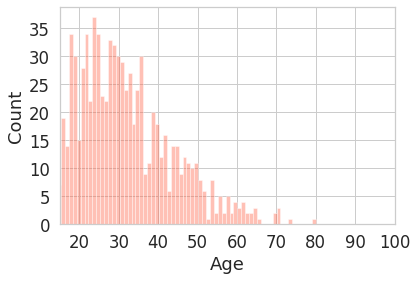

In [0]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(titanic["Age"].dropna(),
                 bins=80,
                 kde=False,
                 color="tomato")
    # sns.plt.title("Age Distribution")
    plt.ylabel("Count")
    plt.xlim((15,100));

### 모델링

In [0]:
!pip install sklearn

In [0]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.model_selection import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age","SibSp", "Parch", "Fare",
              "Embarked","NlengthD", "FsizeD", "Title","Deck"]
target="Survived"
# Initialize our algorithm class
alg = LinearRegression()

# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(n_splits=5,random_state=0,shuffle=False)

predictions = []

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [0]:
for train, test in kf.split(titanic):
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = titanic[target].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

In [0]:
predictions = np.concatenate(predictions, axis=0)
# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0


accuracy=sum(titanic["Survived"]==predictions)/len(titanic["Survived"])
accuracy

0.7991021324354658

In [0]:
# from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

predictors = ["Pclass", "Sex", "Fare", "Embarked","Deck","Age",
              "FsizeD", "NlengthD","Title","Parch"]

# Initialize our algorithm
lr = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)

scores = cross_val_score(lr, titanic[predictors], titanic["Survived"],scoring='f1', cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.7490431890325538


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [0]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
# from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_predict

import numpy as np
predictors = ["Pclass", "Sex", "Age",
              "Fare","NlengthD","NameLength", "FsizeD", "Title","Deck"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
rf = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, 
                            min_samples_leaf=1)
kf = KFold(n_splits=5,random_state=0,shuffle=False)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)

predictions = cross_val_predict(rf, titanic[predictors],titanic["Survived"],cv=kf)
predictions = pd.Series(predictions)
scores = cross_val_score(rf, titanic[predictors], titanic["Survived"],
                                          scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.7409372586695804


In [0]:
predictors = ["Pclass", "Sex", "Age",
              "Fare","NlengthD","NameLength", "FsizeD", "Title","Deck","TicketNumber"]
rf = RandomForestClassifier(random_state=1, n_estimators=50, max_depth=9,min_samples_split=6, min_samples_leaf=4)
rf.fit(titanic[predictors],titanic["Survived"])
kf = KFold(n_splits=5,random_state=0,shuffle=False)
predictions = cross_val_predict(rf, titanic[predictors],titanic["Survived"],cv=kf)
predictions = pd.Series(predictions)
scores = cross_val_score(rf, titanic[predictors], titanic["Survived"],scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.7652997287826453


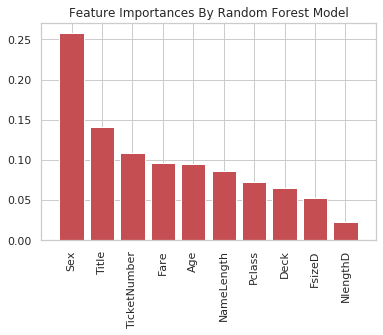

In [0]:
importances=rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
#predictors=titanic.columns
plt.figure()
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(predictors)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)]);

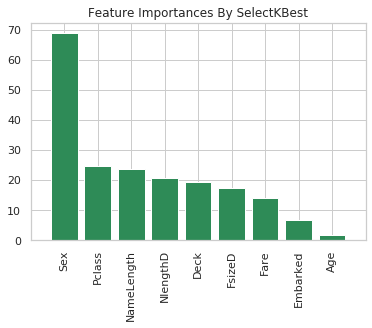

In [0]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.cross_validation import KFold
%matplotlib inline
import matplotlib.pyplot as plt
#predictors = ["Pclass", "Sex", "Age", "Fare",
 #             "FsizeD", "Embarked", "NlengthD","Deck","TicketNumber"]
predictors = ["Pclass", "Sex", "Age",
              "Fare","NlengthD", "FsizeD","NameLength","Deck","Embarked"]
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

indices = np.argsort(scores)[::-1]

sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])

plt.figure()
plt.title("Feature Importances By SelectKBest")
plt.bar(range(np.size(predictors)), scores[indices],
       color="seagreen", yerr=std[indices], align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)]);

In [0]:
from sklearn.linear_model import LogisticRegression
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck"]

# Initialize our algorithm
lr = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.  
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)
scores = cross_val_score(lr, titanic[predictors], titanic["Survived"], scoring='f1',cv=cv)
print(scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.7520867707001014


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [0]:
from sklearn.ensemble import AdaBoostClassifier
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck","TicketNumber"]
adb=AdaBoostClassifier()
adb.fit(titanic[predictors],titanic["Survived"])
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)
scores = cross_val_score(adb, titanic[predictors], titanic["Survived"], scoring='f1',cv=cv)
print(scores.mean())

0.7543612348332751


In [0]:
predictions=["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck","NameLength","TicketNumber"]
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[
        ('lr', lr), ('rf', rf), ('adb', adb)], voting='soft')
eclf1 = eclf1.fit(titanic[predictors], titanic["Survived"])
predictions=eclf1.predict(titanic[predictors])
predictions

test_predictions=eclf1.predict(titanic_test[predictors])

test_predictions=test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })

submission.to_csv("titanic_submission.csv", index=False)